
# Determining and plotting the altitude/azimuth of a celestial object including magnitudes and types of objects for October 2021 

This example demonstrates coordinate transformations and the creation of
visibility curves to assist with observing run planning.

In this example, we make a `~astropy.coordinates.SkyCoord` instance for M33.
The altitude-azimuth coordinates are then found using
`astropy.coordinates.EarthLocation` and `astropy.time.Time` objects.

This example is meant to demonstrate the capabilities of the
`astropy.coordinates` package. For more convenient and/or complex observation
planning, consider the `astroplan <https://astroplan.readthedocs.org/>`_
package.


*By: Erik Tollerud, Kelle Cruz*

*License: BSD*


- Author Sylvie Dagoret-Campagne
- Creation : 28 June 2021
- Update October 4th 2021

Let's suppose you are planning to visit picturesque Bear Mountain State Park
in New York, USA. You're bringing your telescope with you (of course), and
someone told you M33 is a great target to observe there. You happen to know
you're free at 11:00 pm local time, and you want to know if it will be up.
Astropy can answer that.

Import numpy and matplotlib. For the latter, use a nicer set of plot
parameters and set up support for plotting/converting quantities.



In [58]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

%matplotlib inline

Import the packages necessary for finding coordinates and making
coordinate transformations



In [59]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle

In [60]:
from astroquery.simbad import Simbad

In [61]:
from astropy.table import Table

In [62]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [63]:
import datetime
import timezonefinder, pytz
from calendar import monthrange
import calendar

- label lines
https://github.com/cphyc/matplotlib-label-lines

In [64]:
from labellines import labelLine, labelLines

In [65]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [66]:
def makePolarPlot(azimuthsInDegrees, zenithAngles, marker=".",ax=None,
                       title=None, color=None, objName=None,lw=0.5):
    if ax==None:
        _ = plt.figure(figsize=(20, 10))
        ax = plt.subplot(111, polar=True)
        
    ax.plot([a*np.pi/180 for a in azimuthsInDegrees], zenithAngles, marker, c=color, label=objName,lw=lw)
    if title:
        ax.set_title(title, va='bottom')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(0, 90)
    return ax


# Initialisation:

## Observation location

In [67]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

## Determination of UTC offset from Time zone in Chile

In [68]:
tf = timezonefinder.TimezoneFinder()

In [69]:
timezone_str = tf.certain_timezone_at(lat=latitude.degree, lng=longitude.degree)

In [70]:
timezone_str 

'America/Santiago'

In [71]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.datetime.utcnow()
    timeChile_now = datetime.datetime.now(timezone)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

The UTC Time now 2021-10-08 20:53:50.595075
The actual time in America/Santiago is 2021-10-08 17:53:50.595075


In [72]:
utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -3.0  hours


## Initialisation of Simbad

In [73]:
# to view the list of VOTABLE
# Simbad.list_votable_fields()

In [74]:
Simbad.add_votable_fields('sptype')
Simbad.add_votable_fields('flux(U)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(B)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(V)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(R)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(I)') # add the Vega unit Magnitude 
#Simbad.add_votable_fields('flux_unit(V)')
#Simbad.add_votable_fields('flux_unit(I)')
#Simbad.add_votable_fields('flux_system(V)')
#Simbad.add_votable_fields('flux_system(I)')
#Simbad.add_votable_fields('ubv')  # Johnson UBV system

## Targets

In [75]:
#all_target_names= ["hd111980","hd101452","hd115169","hd142331"]
#all_target_names=['FEIGE110', 'GD108', 'GD50', 'HD009051', 'HD031128','HD074000', 'HD111980', 'HD14943', 'HD160617', 'HD185975','HD200654', 'HD205905', 'HD37962', 'HD38949', 'HD60753','LTT9491', 'NGC7293', 'SIRIUS', 'WD0308-565']
#all_target_names=['HD009051','HD14943']
#all_target_names=['HD002811','PNG321.0+03.9']
all_target_names=['HD2811','HD009051','HD14943','HD031128','LAM LEP','HD37962','mu. Col',
                 'HD38949','ETA1 DOR','HD60753','HD074000','HD160617','HD167060','HD185975',
                  'HD200654','HD205905']
NTargets=len(all_target_names)

In [76]:
all_target_locations = [ SkyCoord.from_name(target_name) for target_name in all_target_names]

In [77]:
all_target_locations[0]

<SkyCoord (ICRS): (ra, dec) in deg
    (7.82704127, -43.60638897)>

In [78]:
all_ra=[]
all_dec=[]
for target_loc in all_target_locations:
    all_ra.append(target_loc.ra)
    all_dec.append(target_loc.dec)

In [79]:
all_Vmag = []
all_types = []
all_target_tagnames = []
for target_name in all_target_names:
    result_table = Simbad.query_object(target_name)
    all_Vmag.append(result_table['FLUX_V'][0])
    all_types.append(result_table['SP_QUAL'][0]) 
    tagname =  target_name + ", t=" + result_table['SP_QUAL'][0] + ", m=" + str(result_table['FLUX_V'][0])
    print(tagname)
    all_target_tagnames.append(tagname)

HD2811, t=C, m=7.5
HD009051, t=D, m=8.92
HD14943, t=C, m=5.898
HD031128, t=D, m=9.14
LAM LEP, t=C, m=4.29
HD37962, t=C, m=7.85
mu. Col, t=C, m=5.18
HD38949, t=C, m=7.8
ETA1 DOR, t=C, m=5.69
HD60753, t=C, m=6.68
HD074000, t=D, m=9.66
HD160617, t=D, m=8.73
HD167060, t=C, m=8.92
HD185975, t=C, m=8.1
HD200654, t=C, m=9.11
HD205905, t=C, m=6.74


In [80]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTargets)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTargets), alpha=1)

## Observation Date

In [81]:
NYEAR=2021
NMONTH=10
NDAY=6

In [82]:
night_obs= datetime.datetime(NYEAR, NMONTH, NDAY, 0, 0)
night_obs_midnight= datetime.datetime(NYEAR, NMONTH, NDAY, 23, 59,59)

In [83]:
night_obs_midnight

datetime.datetime(2021, 10, 6, 23, 59, 59)

In [84]:
night_obs_str=night_obs.strftime("%Y-%m-%d %H:%M:%S")
night_obs_str

'2021-10-06 00:00:00'

In [85]:
night_obs_midnight_str=night_obs_midnight.strftime("%Y-%m-%d %H:%M:%S")
night_obs_midnight_str

'2021-10-06 23:59:59'

## Time zone at observation

In [86]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = night_obs_midnight
    
    print("The UTC Time at observation %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

The UTC Time at observation 2021-10-06 23:59:59
The actual time in America/Santiago is 2021-10-06 20:59:59


In [87]:
utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -3.0  hours


In [88]:
utcoffset=utcoffset*u.hour  # need hours units

## Observation Location

In [89]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

In [90]:
cerro_pachon = EarthLocation(lat=latitude.degree*u.deg, lon=longitude.degree*u.deg, height=altitude)

## Check Position of target at midnight

http://catserver.ing.iac.es/staralt/

# Observation frame

In [91]:
midnight_utc = Time(night_obs_midnight_str) - utcoffset
delta_midnight = np.linspace(-2, 10, 100)*u.hour
frame_night = AltAz(obstime=midnight_utc+delta_midnight,location=cerro_pachon)

In [92]:
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times_evening_to_morning = midnight_utc + delta_midnight
frame_evening_to_morning = AltAz(obstime=times_evening_to_morning, location=cerro_pachon)

### Sun frame

In [93]:
from astropy.coordinates import get_sun
sunaltazs_evening_to_morning = get_sun(times_evening_to_morning).transform_to(frame_evening_to_morning)

### Moon frame

In [94]:
from astropy.coordinates import get_moon
moon_evening_to_morning = get_moon(times_evening_to_morning)
moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

### Target frame

In [95]:
all_target_altazs_evening_to_morning = [target_location.transform_to(frame_evening_to_morning) for target_location in  all_target_locations ]

# Order according increasing maxinum rise time

In [96]:
from astropy.coordinates import Angle

In [97]:
all_timemax=np.zeros(NTargets)
all_altitudesmax=np.zeros(NTargets)
for idx in np.arange(NTargets):
    altitudes=all_target_altazs_evening_to_morning[idx].alt
    idx_max=np.where(altitudes==altitudes.max())[0][0]
    all_timemax[idx]=delta_midnight[idx_max].value
    all_altitudesmax[idx]=altitudes.max().degree

In [98]:
Angle(altitudes.max()).degree

86.96882050395877

In [99]:
all_timemax

array([ 1.18918919,  2.15015015,  3.03903904,  5.51351351,  5.96996997,
        6.33033033,  6.4024024 ,  6.45045045,  6.73873874,  8.2042042 ,
        9.33333333, -5.58558559, -5.00900901, -2.7027027 , -2.1981982 ,
       -1.66966967])

In [100]:
sorted_indexes=np.argsort(all_timemax)

In [101]:
sorted_all_timemax=sorted(all_timemax)
sorted_all_timemax

[-5.585585585585585,
 -5.009009009009009,
 -2.7027027027027035,
 -2.198198198198199,
 -1.6696696696696698,
 1.1891891891891895,
 2.15015015015015,
 3.0390390390390394,
 5.513513513513512,
 5.96996996996997,
 6.33033033033033,
 6.4024024024024015,
 6.45045045045045,
 6.738738738738739,
 8.204204204204203,
 9.333333333333332]

# Plot

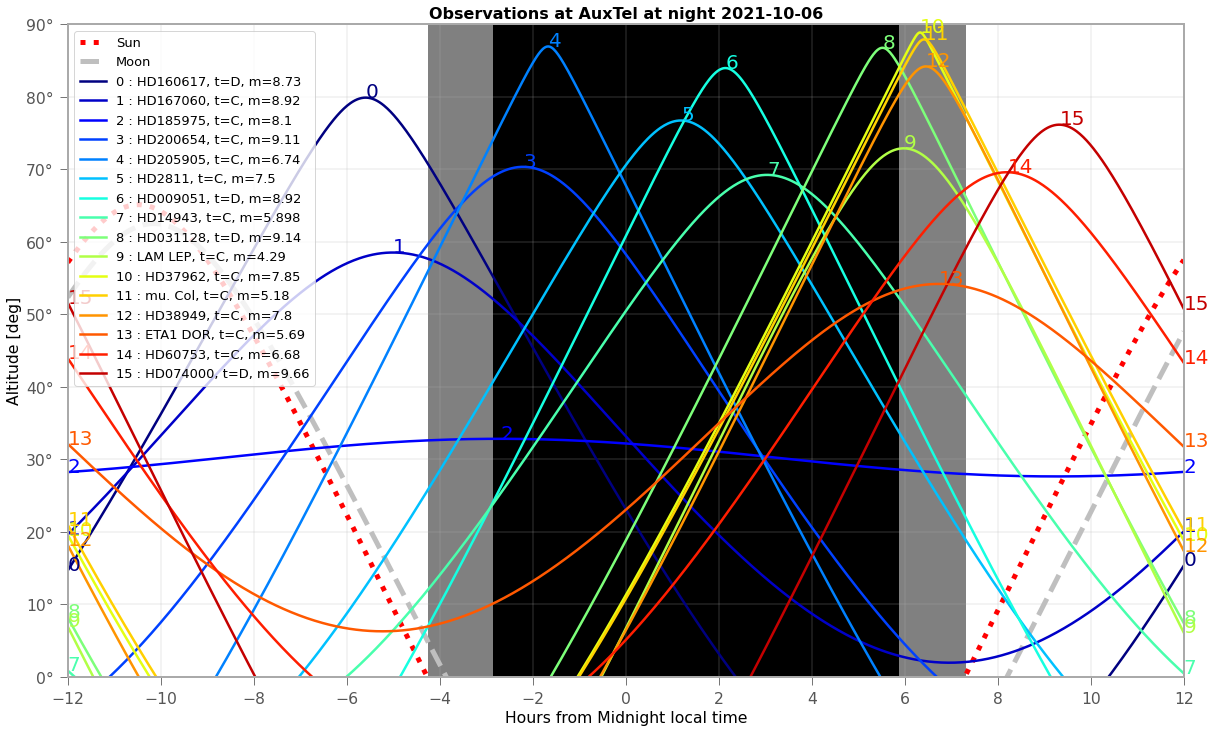

In [102]:
plt.figure(figsize=(20,12))
plt.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
plt.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)

rank=0
for idx in sorted_indexes:
    label=str(rank)+" : "+all_target_tagnames[idx]
    plt.plot(delta_midnight, all_target_altazs_evening_to_morning[idx].alt,label=label, lw=2.5,color=all_colors[rank])

    if all_target_altazs_evening_to_morning[idx].alt[-1]>0:
        plt.text(delta_midnight[-1], all_target_altazs_evening_to_morning[idx].alt[-1], f'{rank}',color=all_colors[rank],fontsize=20)
    if all_target_altazs_evening_to_morning[idx].alt[0]>0:
        plt.text(delta_midnight[0], all_target_altazs_evening_to_morning[idx].alt[0], f'{rank}',color=all_colors[rank],fontsize=20)
    if all_altitudesmax[idx]:
        plt.text(all_timemax[idx], all_altitudesmax[idx], f'{rank}',color=all_colors[rank],fontsize=20)
    
    rank+=1
    
#labelLines(plt.gca().get_lines(), zorder=2.5)
#labelLines(plt.gca().get_lines(), align=False, fontsize=14)
#xvals=sorted(all_timemax)
#labelLines(plt.gca().get_lines(), align=False, xvals=xvals, color="k")
#labelLines(plt.gca().get_lines(), xvals=(-10., 10.), zorder=2.5)


plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

plt.legend(loc='upper left')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2-12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from Midnight local time')
plt.ylabel('Altitude [deg]')
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
plt.title(title)

figname="AuxtelStarAlt_{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.savefig(figname)
plt.show()

# Create astropy Table

In [103]:
t = Table()

In [104]:
t["name"] = all_target_names
t["ra"] = all_ra
t["dec"] = all_dec
t["type"] = all_types 
t["Vmag"] = all_Vmag  
t["tculmin"] = all_timemax

In [105]:
t["ra"].info.format ='5.3f'
t["dec"].info.format ='5.3f'
t["Vmag"].info.format ='5.3f'
t["tculmin"].info.format ='5.3f'

In [106]:
t.show_in_notebook()

idx,name,ra,dec,type,Vmag,tculmin
,,deg,deg,,,
0,HD2811,7.827,-43.606,C,7.500,1.189
1,HD009051,22.194,-24.340,D,8.920,2.150
2,HD14943,35.728,-51.092,C,5.898,3.039
3,HD031128,73.041,-27.064,D,9.140,5.514
4,LAM LEP,79.894,-13.177,C,4.290,5.970
5,HD37962,85.217,-31.351,C,7.850,6.330
6,mu. Col,86.500,-32.306,C,5.180,6.402
7,HD38949,87.084,-24.464,C,7.800,6.450
8,ETA1 DOR,91.539,-66.040,C,5.690,6.739


In [107]:
t

name,ra,dec,type,Vmag,tculmin
,deg,deg,,,
str8,float64,float64,str1,float32,float64
HD2811,7.827,-43.606,C,7.500,1.189
HD009051,22.194,-24.340,D,8.920,2.150
HD14943,35.728,-51.092,C,5.898,3.039
HD031128,73.041,-27.064,D,9.140,5.514
LAM LEP,79.894,-13.177,C,4.290,5.970
HD37962,85.217,-31.351,C,7.850,6.330
mu. Col,86.500,-32.306,C,5.180,6.402
HD38949,87.084,-24.464,C,7.800,6.450


<ipython-input-108-5cfe21335a9b>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  azimuthsInDegreesNight=azimuthsInDegrees[darkTimeIndex]
<ipython-input-108-5cfe21335a9b>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  zenithAnglesNight=zenithAngles[darkTimeIndex]
<ipython-input-108-5cfe21335a9b>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in

Text(0.5, 1.0, 'Observations at AuxTel at night 2021-10-06')

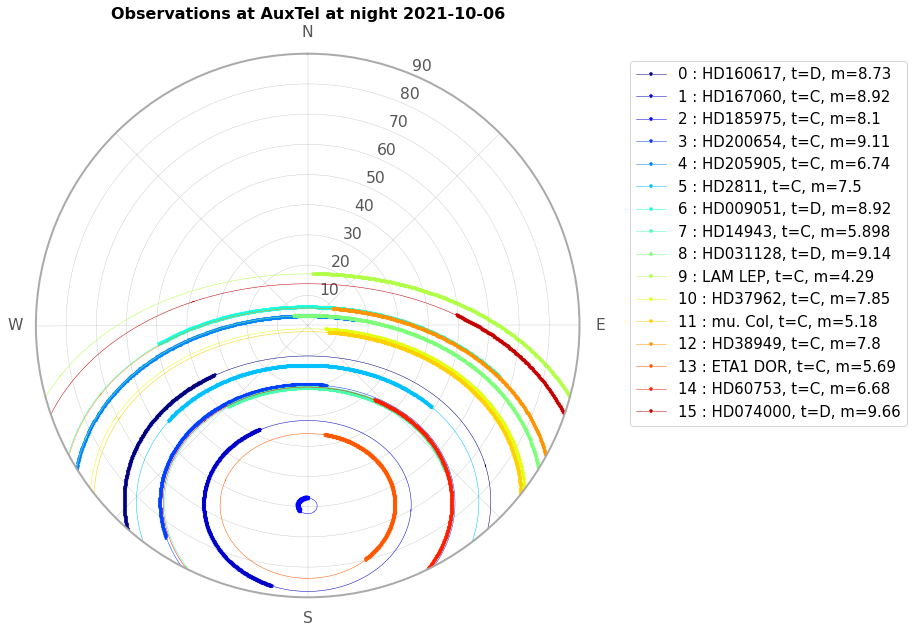

In [108]:
_ = plt.figure(figsize=(20, 10))

ax = plt.subplot(111, polar=True)

rank=0

darkTimeIndex=[sunaltazs_evening_to_morning.alt < -18*u.deg]

for idx in sorted_indexes:
    shortlabel=str(rank)
    label=str(rank)+" : "+all_target_tagnames[idx]
    
    
    azimuthsInDegrees=Angle(all_target_altazs_evening_to_morning[idx].az).deg
    zenithAngles = Angle(all_target_altazs_evening_to_morning[idx].zen).deg
    
    ax=makePolarPlot(azimuthsInDegrees, zenithAngles,ax=ax, marker="-",title=None, color=all_colors[rank], lw=0.5)
    
    azimuthsInDegreesNight=azimuthsInDegrees[darkTimeIndex]
    zenithAnglesNight=zenithAngles[darkTimeIndex]
    ax=makePolarPlot(azimuthsInDegreesNight, zenithAnglesNight,ax=ax ,marker="*-",title=None, color=all_colors[rank],objName=label,lw=0.5)
    
    thex=zenithAnglesNight[0]*np.sin( (azimuthsInDegreesNight[0]) *np.pi/180.)
    they=zenithAnglesNight[0]*np.cos( (azimuthsInDegreesNight[0])*np.pi/180.)
   
    #plt.text(thex, they,f'{rank}',color=all_colors[rank],fontsize=20)
    
    rank+=1
 


 
ax.legend(bbox_to_anchor=(1.08, 1), prop={'size': 15}, loc='upper left')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)